In [16]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.vizier import Vizier
from dustmaps.sfd import SFDQuery 
from dustmaps.bayestar import BayestarQuery

bayestar = BayestarQuery(max_samples=2)
sfd = SFDQuery()


Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 23.032 s
  pix_info:   0.562 s
   samples:  10.259 s
      best:   4.819 s
       nan:   0.187 s
      sort:   7.024 s
       idx:   0.183 s


/Users/wzx/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


3d failed , turn to sfd


/Users/wzx/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1688: RuntimeWarning: invalid value encountered in less
  resdat[resdat < 0] = 0


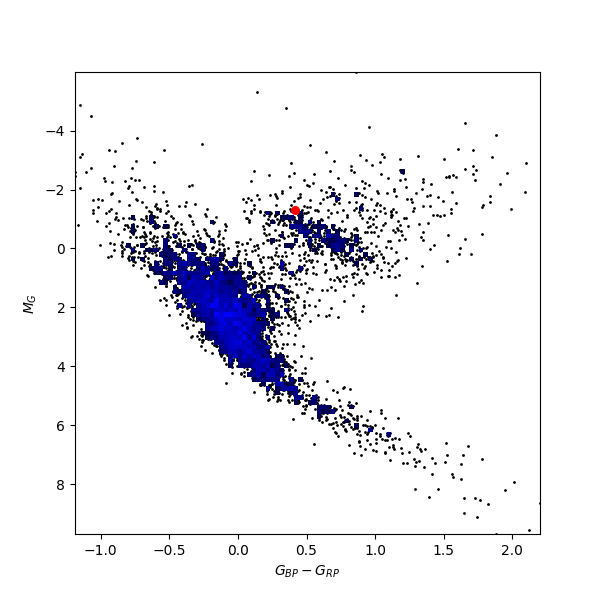

In [97]:
def h2d(string):
    ra, dec = string.split()
    sgn = 1
    if '-' in dec:
        sgn = -1
    dec = dec.replace('-', '')
    a, b, c = [float(i) for i in ra.split(':')]
    d, e, f = [float(i) for i in dec.split(':')]

    alpha = (a + b/60 + c/3600)*15
    delta = sgn*(d + e/60 + f/3600)
    return alpha, delta

def HR_diagram(ra_dec=None,ra=None,dec=None,figtype='HR',sfd_corr=True,display_filter=False,locate=False):
    if ra_dec:
        ra, dec = h2d(ra_dec)
    src = SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg), frame='icrs')
    kwd = ['+_r', 'RA_ICRS', 'DE_ICRS', 'Source', 'Dist', 'b_Dist', 'B_Dist', 'BP-RP', 'Gmag',
           'e_Gmag', 'e_BPmag', 'Plx', 'e_Plx','RPlx', 'e_RPmag', 'RUWE', 'epsi', 'sepsi',
            'E(BP/RP)', 'AG','RFG','RFBP','RFRP','Nper','NgAL','chi2AL']
    v = Vizier(columns=kwd)
    v.ROW_LIMIT = -1
    result = v.query_region(src, radius="15m", catalog=["I/355/gaiadr3"])
    tab = result[0]
#   filtering
    tab = tab[np.logical_and(tab['RPlx'] > 5,tab['Nper'] > 4,tab['NgAL'] > 5)]
    tab = tab[tab['chi2AL']/(tab['NgAL']-5) < 1.44*np.array([max([1,i]) for i in np.exp(-0.4*(tab['Gmag']-19.5))])]
    tab = tab[np.logical_and(tab['RFG'] > 50,tab['RFBP'] > 20,tab['RFRP'] > 20)]
    tab = tab[1.0+0.05*tab['BP-RP']**2 < tab['E_BP_RP_']]
    tab = tab[tab['E_BP_RP_']< 1.2+0.05*tab['BP-RP']**2]
    tab = tab[np.logical_or(tab['epsi'] < 1, tab['sepsi'] < 2)]


    from astroquery.xmatch import XMatch
    tab = XMatch.query(cat1=tab, cat2='vizier:I/352/gedr3dis',
                       max_distance=1*u.arcsec, colRA1='RA_ICRS', colDec1='DE_ICRS')
    tab = tab[tab['Source_1'] == tab['Source_2']]
    tab = tab[tab['B_rgeo']-tab['b_rgeo']<1/3*tab['rgeo']]

    if display_filter:
        fig, ax = plt.subplots(figsize=(6, 6))
        plt.scatter(tab['BP-RP'], tab['E_BP_RP_'], s=1)
        plt.show()

    ra = tab['RA_ICRS_1']
    dec = tab['DE_ICRS_1']
    dist = tab['rgeo']
    coords = SkyCoord(ra*u.deg, dec*u.deg, distance=dist*u.pc, frame='icrs')
    ebv = bayestar(coords, mode='median')
    if np.isnan(ebv[0]) and np.isnan(ebv[-1]):
        print('3d failed , turn to sfd')
        ebv = sfd(coords)
    ebprp = 1.329*ebv
    R_G = 2.516

    BP_RP = tab['BP-RP'] - ebprp*sfd_corr
    M_G = tab['Gmag'] + 5*np.log10(10/tab['rgeo']) - ebv*R_G*sfd_corr
    m_G = tab['Gmag'] - ebv*R_G*sfd_corr

    src = tab[0]
    src_mag = M_G[0] if figtype == 'HR' else m_G[0]
    src_BP_RP = BP_RP[0]
    xerr = (src['e_BPmag']**2+src['e_RPmag']**2)**0.5
    yerr = [[5*np.log10(src['rgeo']/src['b_rgeo']),5*np.log10(src['B_rgeo']/src['rgeo'])]] if figtype == 'HR' else src['e_Gmag']
    yerr = np.array(yerr).T
    c = 'r' if src['_r'] < 1 else 'lime'
# plotter
    %matplotlib widget
    from matplotlib import colors
    grad = [(0, 0, 0.3), (0, 0, 1)]
    cm = colors.LinearSegmentedColormap.from_list(
            "Custom", grad, N=10)
    fig, ax = plt.subplots(figsize=(6, 6))
    if figtype=='HR':
        ax.scatter(BP_RP, M_G, s=1,c='black')
        h = ax.hist2d(BP_RP, M_G, bins=100, cmin=3, norm=colors.PowerNorm(0.5),cmap=cm)
        ax.errorbar(src_BP_RP,src_mag,xerr=xerr,yerr=yerr,c=c)
        ax.scatter(src_BP_RP,src_mag,s=30,c=c)
        if locate:
            x,y = src_BP_RP,src_mag
            arrowprops={'arrowstyle': '-', 'ls':'--'}
            ax.annotate('{:.2f}'.format(x), xy=(x,y), xytext=(x, 0), 
                textcoords=plt.gca().get_xaxis_transform(),
                arrowprops=arrowprops,
                va='top', ha='center')
            ax.annotate('{:.2f}'.format(y), xy=(x,y), xytext=(0, y), 
                        textcoords=plt.gca().get_yaxis_transform(),
                        arrowprops=arrowprops,
                        va='center', ha='right')
        ax.invert_yaxis()
        ax.set_xlabel(r'$G_{BP} - G_{RP}$')
        ax.set_ylabel(r'$M_G$')
    elif figtype == 'CMB':
        ax.scatter(BP_RP, m_G, s=1,c='black')
        h = ax.hist2d(BP_RP, m_G, bins=100, cmin=3, norm=colors.PowerNorm(0.5),cmap=cm)
        ax.errorbar(src_BP_RP,src_mag,xerr=xerr,yerr=yerr,c=c)
        ax.scatter(src_BP_RP,src_mag,s=30,c=c)
        if locate:
            x,y = src_BP_RP,src_mag
            arrowprops={'arrowstyle': '-', 'ls':'--'}
            ax.annotate('{:.2f}'.format(x), xy=(x,y), xytext=(x, 0), 
                textcoords=plt.gca().get_xaxis_transform(),
                arrowprops=arrowprops,
                va='top', ha='center')
            ax.annotate('{:.2f}'.format(y), xy=(x,y), xytext=(0, y), 
                        textcoords=plt.gca().get_yaxis_transform(),
                        arrowprops=arrowprops,
                        va='center', ha='right')
        ax.invert_yaxis()
        ax.set_xlabel(r'$m_{G_{BP}} - m_{G_{RP}}$')
        ax.set_ylabel(r'$m_G$')
    plt.show()

HR_diagram("10:38:42.42 -61:15:49.68",figtype='HR',sfd_corr=1)
